# Train Everything

This notebook uses the RGZ labels to train on *everything* we can, and makes predictions for every SWIRE object within 1' of a radio component. It is tested against RGZ (which is all we really have to work with if we're predicting on everything).

In [1]:
import astropy.io.ascii as asc, numpy, h5py, sklearn.linear_model, crowdastro.crowd.util, pickle, scipy.spatial
import matplotlib.pyplot as plt
%matplotlib inline
with open('/Users/alger/data/Crowdastro/sets_atlas.pkl', 'rb') as f:
    atlas_sets = pickle.load(f)
    atlas_sets_compact = atlas_sets['RGZ & compact']
    atlas_sets_resolved = atlas_sets['RGZ & resolved']
with open('/Users/alger/data/Crowdastro/sets_swire.pkl', 'rb') as f:
    swire_sets = pickle.load(f)
    swire_sets_compact = swire_sets['RGZ & compact']
    swire_sets_resolved = swire_sets['RGZ & resolved']
with h5py.File('/Users/alger/data/Crowdastro/swire.h5') as f:
    swire_features = f['features'].value
with h5py.File('/Users/alger/data/Crowdastro/crowdastro-swire.h5') as f:
    swire_names = [i.decode('ascii') for i in f['/swire/cdfs/string'].value]
    swire_coords = f['/swire/cdfs/numeric'][:, :2]
swire_labels = {i['swire']: i['rgz_label'] for i in asc.read('/Users/alger/data/SWIRE/all_labels.csv')}
table = asc.read('/Users/alger/data/Crowdastro/one-table-to-rule-them-all.tbl')
swire_tree = scipy.spatial.KDTree(swire_coords)

In [2]:
import collections
swire_to_probs = collections.defaultdict(list)

for (train, test), (_, test_swire) in zip(atlas_sets['RGZ'], swire_sets['RGZ']):
    key_to_row = {}
    for row in table:
        key_to_row[row['Key']] = row
    # Get coords.
    ras = [key_to_row[k]['Component RA (Franzen)'] for k in train]
    decs = [key_to_row[k]['Component DEC (Franzen)'] for k in train]
    coords = list(zip(ras, decs))
    # Find nearby SWIREs.
    nearby = sorted({int(i) for i in numpy.concatenate(swire_tree.query_ball_point(coords, 1 / 60))})
    # Train on the features.
    features = swire_features[nearby]
    labels = [swire_labels[swire_names[n]] == 'True' for n in nearby]
    lr = sklearn.linear_model.LogisticRegression(class_weight='balanced', C=1e10)
    lr.fit(features, labels)
    # Predict on the test set.
    test_labels = [swire_labels[swire_names[n]] == 'True' for n in test_swire]
    test_features = swire_features[test_swire]
    acc = crowdastro.crowd.util.balanced_accuracy(test_labels, lr.predict(test_features))
    print(acc)
    probs = lr.predict_proba(test_features)
    for n, p in zip(test_swire, probs):
        swire_to_probs[n].append(p)

0.876911896501
0.845826136855
0.86048508232
0.839901715101


In [12]:
swires = numpy.ma.MaskedArray(numpy.zeros(max(swire_to_probs) + 1), mask=numpy.ones(max(swire_to_probs) + 1))
swires.mask[sorted(swire_to_probs)] = 0
for n in swire_to_probs:
    swires[n] = numpy.mean(swire_to_probs[n], axis=0)[1]

In [15]:
assert swires.mask.sum() == 0

## Distribution of predictions

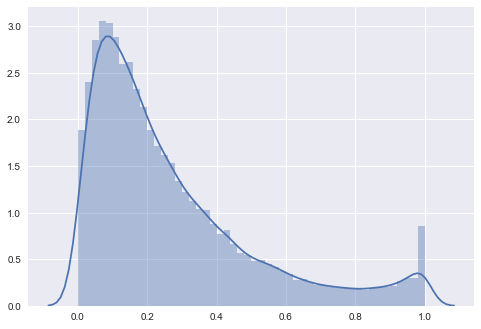

In [19]:
import seaborn
seaborn.distplot(swires)

In [20]:
with h5py.File('/Users/alger/data/Crowdastro/predictions_swire_all.h5', 'w') as f:
    f.create_dataset('predictions', data=swires)